In [1]:
%load_ext autoreload
%autoreload 2

import utils

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, precision_score, recall_score

In [3]:
df = utils.get_wide_df()
df.head(2)

,Unnamed: 0.1,Unnamed: 0,assignment_level,attempts_date_created,cl_date_assignment,cl_id,cls_date_created,cls_student_id,course_id,is_solved,problem_id,subject_slug,team_id,team_level,tp_teacher_id
0,0,0,3,2022-03-08 11:02:37+03:00,2022-03-05 13:00:00+03:00,71374307,2022-03-08 10:52:43+03:00,1650006,5096626,1,97304,mathematics,82516,4,520541
1,1,1,3,2022-03-08 11:02:49+03:00,2021-09-02 14:23:50+03:00,70879797,2022-03-08 11:02:08+03:00,1494142,5099807,1,227546,mathematics,69290,4,615530


In [4]:
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
df.head(2)

,assignment_level,attempts_date_created,cl_date_assignment,cl_id,cls_date_created,cls_student_id,course_id,is_solved,problem_id,subject_slug,team_id,team_level,tp_teacher_id
0,3,2022-03-08 11:02:37+03:00,2022-03-05 13:00:00+03:00,71374307,2022-03-08 10:52:43+03:00,1650006,5096626,1,97304,mathematics,82516,4,520541
1,3,2022-03-08 11:02:49+03:00,2021-09-02 14:23:50+03:00,70879797,2022-03-08 11:02:08+03:00,1494142,5099807,1,227546,mathematics,69290,4,615530


In [5]:
df_train, df_test = utils.split_train_test(df)
df_train.shape, df_test.shape

((3003185, 13), (943531, 13))

In [6]:
df_train.shape

(3003185, 13)

In [7]:
class ConstModel():
    def predict(self, X: np.array):
        res = np.ones(X.shape[0])
        return res
    
    @property
    def name(self):
        return "const"
const_model = ConstModel()

In [8]:
pred = const_model.predict(df_test)

In [9]:
fpr = dict()
tpr = dict()
precision = dict()
recall = dict()
roc_auc = dict()

In [59]:
def evaluate(name, pred_proba, pred, y_true):
    fpr[name], tpr[name], _ = roc_curve(y_true, pred_proba)
    roc_auc[name] = auc(fpr[name], tpr[name])
    precision[name] = precision_score(y_true, pred)
    recall[name] = recall_score(y_true, pred)
    print(f"precision:{precision[name]}, recall:{recall[name]}")

    plt.figure()
    lw = 2
    plt.plot(
        fpr[name], tpr[name],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[name],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic for " + name)
    plt.legend(loc="lower right")
    plt.show()

precision:0.7256104992840723, recall:1.0


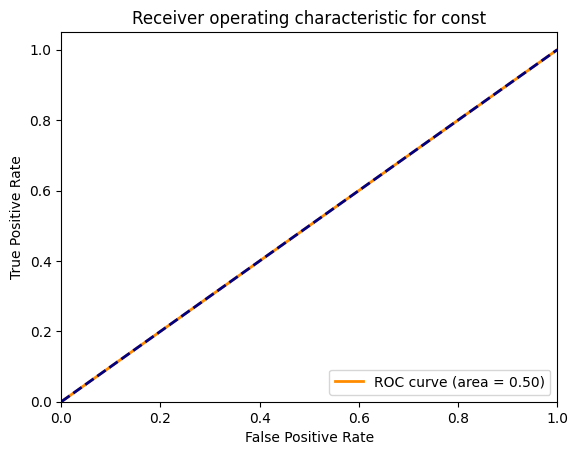

In [60]:
pred = const_model.predict(df_test)
evaluate('const', pred, pred, df_test['is_solved'])

In [61]:
problem_info = df_train.groupby(by=['problem_id'])[['is_solved']].mean()
problem_info.columns = ['mean_problem_solved']

In [62]:
students_info = df_train.groupby(by=['cls_student_id'])[['is_solved']].mean()
students_info.columns = ['mean_student_solved']

In [63]:
lin_df_train = df_train[['problem_id', 'cls_student_id', 'is_solved']]
lin_df_test = df_test[['problem_id', 'cls_student_id', 'is_solved']]

lin_df_train = lin_df_train.join(problem_info, on='problem_id')
lin_df_train = lin_df_train.join(students_info, on='cls_student_id')

lin_df_test = lin_df_test.join(problem_info, on='problem_id')
lin_df_test = lin_df_test.join(students_info, on='cls_student_id')

lin_df_train.head(2)

,problem_id,cls_student_id,is_solved,mean_problem_solved,mean_student_solved
0,20000,1550166,0,0.571429,0.825301
1,20000,1550167,1,0.571429,0.877246


In [64]:
lin_X_train = lin_df_train[['mean_problem_solved', 'mean_student_solved']] 
lin_y_train = lin_df_train['is_solved']

lin_X_test = lin_df_test[['mean_problem_solved', 'mean_student_solved']] 
lin_y_test = lin_df_test['is_solved']

In [65]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

precision:0.7869710379345073, recall:0.9416200725641071


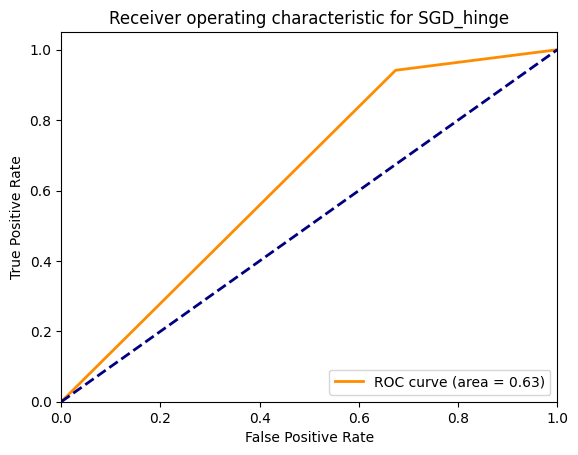

In [66]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(lin_X_train, lin_y_train)

pred = clf.predict(lin_X_test)
evaluate("SGD_hinge", pred, pred, lin_y_test)

precision:0.7961707750901911, recall:0.9257795383240145


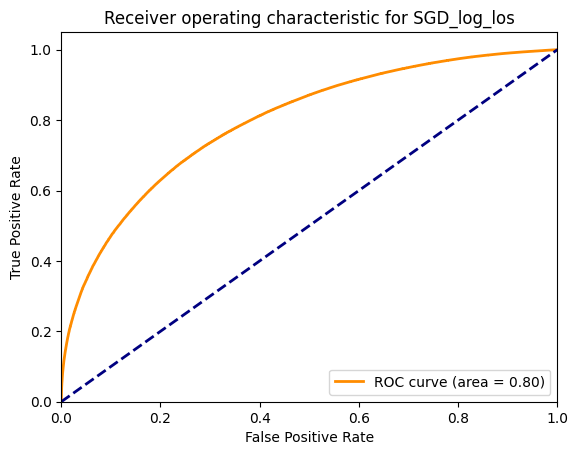

In [67]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss'))
clf.fit(lin_X_train, lin_y_train)

pred_proba = clf.predict_proba(lin_X_test)[:,1]
pred = clf.predict(lin_X_test)
evaluate("SGD_log_los", pred_proba, pred, lin_y_test)

In [68]:
from catboost import CatBoostClassifier

precision:0.7980569145775654, recall:0.9220534707494201


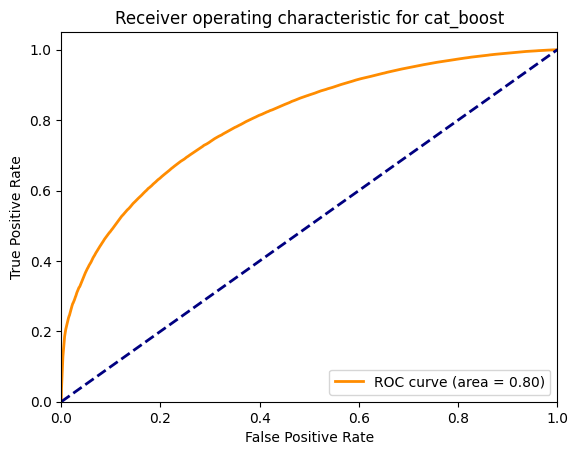

In [69]:
cat_class = CatBoostClassifier(iterations=50, depth=2,
                           task_type="GPU",
                           devices='0:1', logging_level='Silent')
cat_class.fit(lin_X_train, lin_y_train)
pred_proba = cat_class.predict_proba(lin_X_test)[:,1]
pred = cat_class.predict(lin_X_test)
evaluate("cat_boost", pred_proba, pred, lin_y_test)